In [31]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy
from scipy.signal import find_peaks

from matplotlib import colors
from matplotlib import ticker

from sklearn.svm import OneClassSVM

# Waveform selection

- find peak and isolate the waveform

In [32]:
def quick_plot(data, title, axis):
    if len(data)==0:
        axis.plot(data.transpose())
    else:
        for wf in data:
            axis.plot(wf.transpose())
    axis.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
    axis.set_ylabel(r"$\mathrm{\bf ADC\ counts}$")
    axis.set_title(title);

In [33]:
# neutrons = pd.read_pickle('neutrons.pkl')
# print(neutrons.keys())
# fig, axs = plt.subplots(1, 1, figsize=(12, 2))
# quick_plot(neutrons['waveform'][0:20], title='neutron waveforms', axis =axs)

In [34]:
# cosmics = pd.read_pickle('cosmics-1.pkl')
# print(cosmics.keys())
# fig, axs = plt.subplots(1, 1, figsize=(12, 2))
# quick_plot(cosmics['waveform'][0:20], title='cosmics waveforms', axis =axs)

# Data engineering, feature extraction

- for now we do nothing

we may want to extract features of the waveforms like
 - mean, std, skewness...
 - peak amplitude, rise time, fall time, pulse width...
 => i.e. instead of a vector of size ≈300, we will have a few 10's [mean, srd, peak amplitude ...]

OR
 - build a network that looks for the features by itself

# One-Class SVM (OSVM)

### training/testing

- use a fraction of the cosmics to train (TBD)
- use another part to evaluate the performance 
- look at what happens in the nueutron sample (should have some outliers)
- look at what happens in the nueutron SB sample (should have no outliers)

=> find out the right size for the training sample 

 -> start small, increase until it doesn't change anything when we add more events


## Training

- SVM is vector based -> all data points should have the same number of features
- we check the max length of the waveforms and add 0 at the end to reach this number
- TODO: think of something more clever: may want to look at the ouliers (values very far from the mean), it may be worth reducing their size...

In [35]:
def make_training_sample(waveforms, verbose=True, nWfs_plot = 20, force_max = -999):
    lengths = [wf.shape[0] for wf in waveforms]
    mean, min, max = np.array(lengths).mean(), np.array(lengths).min(), np.array(lengths).max()
    print(f'mean: {mean:.1f}, min = {min}, max = {max} ')

    if force_max > -999:
        # if we want to make a sample for inference
        # we need to set the maximum to that of the training sample
        print(f'maximum {force_max} is taken from external input')
        max = force_max


    #TODO: what do we do if we have wafeforms with max>force_max (cf. inference)

    X_train = np.array( [ np.concatenate((wf, np.zeros(max-wf.shape[0])), axis=0) for wf in waveforms if (wf.shape[0] < max)] )

    if verbose:
        plt.hist(lengths, bins=10, edgecolor='black');

        fig, axs = plt.subplots(1, 1, figsize=(12, 2))
        quick_plot(waveforms[:nWfs_plot], title='original waveforms', axis =axs)

        fig, axs = plt.subplots(1, 1, figsize=(12, 2))
        quick_plot(X_train[:nWfs_plot], title='waveforms after', axis =axs)

    return X_train, max

    

mean: 193.4, min = 72, max = 450 
maximum 150 is taken from external input


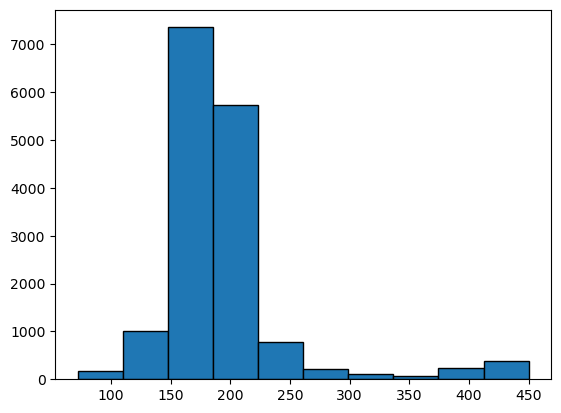

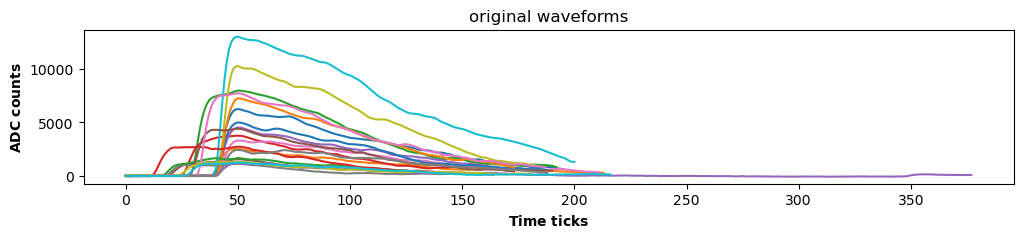

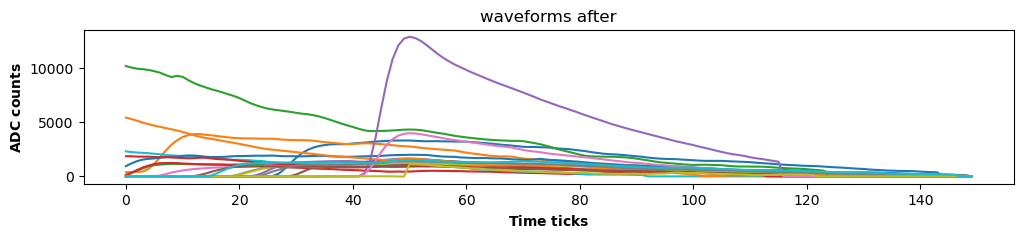

In [44]:
# cosmics-1, neutrons_sideBand
trainSample = pd.read_pickle('neutrons_sideBand.pkl')
X_train, max = make_training_sample(trainSample['waveform'], verbose=True, nWfs_plot = 20, force_max = 150)



In [45]:
# Create an OCSVM model
# check documentation for list of kernels and parameters
## https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', verbose=True) 
 
# Train the model
ocsvm.fit(X_train)

[LibSVM]*
optimization finished, #iter = 172
obj = 1231.952728, rho = 22.337118
nSV = 140, nBSV = 127


OneClassSVM(nu=0.1, verbose=True)

In [46]:
print("Training sample shape", X_train.shape)
print("Hyperparameters:")
print("nu:", ocsvm.nu)
print("kernel:", ocsvm.kernel)
## more stuff
support_vectors = ocsvm.support_vectors_
print("Number of support vectors:", support_vectors.shape[0])

Training sample shape (1337, 150)
Hyperparameters:
nu: 0.1
kernel: rbf
Number of support vectors: 140


## Validation

In [47]:
def print_info(y_pred, verbose=True):
    # predict: Returns -1 for outliers and 1 for inliers.
    Ntot = y_pred.shape[0]
    Nanomalies = (y_pred == -1).sum()
    if verbose: print(f'total number of waveforms: {Ntot}')
    if verbose: print(f'number of outliers detected: {Nanomalies} -> {Nanomalies*100/Ntot:.2f} %')
    return Ntot, Nanomalies


 cosmics-1
mean: 192.0, min = 83, max = 446 
maximum 150 is taken from external input
(173, 150)

 cosmics-2
mean: 194.4, min = 74, max = 448 
maximum 150 is taken from external input
(170, 150)

 cosmics-3
mean: 198.1, min = 68, max = 450 
maximum 150 is taken from external input
(173, 150)

 cosmics-4
mean: 197.2, min = 75, max = 449 
maximum 150 is taken from external input
(195, 150)

 cosmics-5
mean: 196.2, min = 72, max = 449 
maximum 150 is taken from external input
(217, 150)


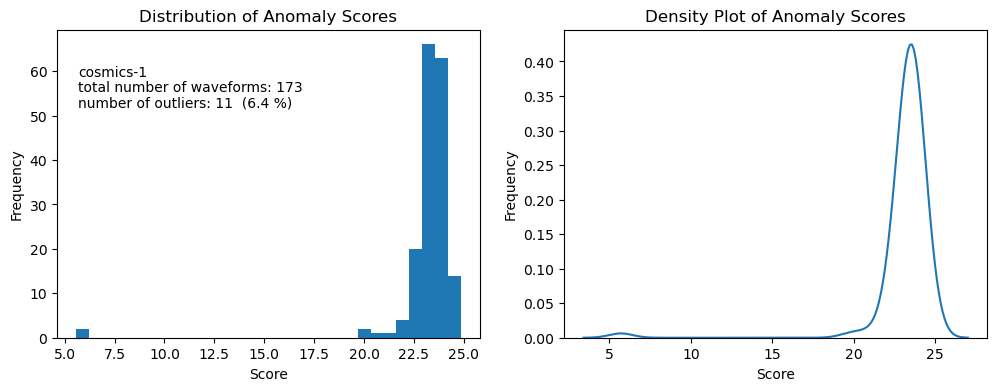

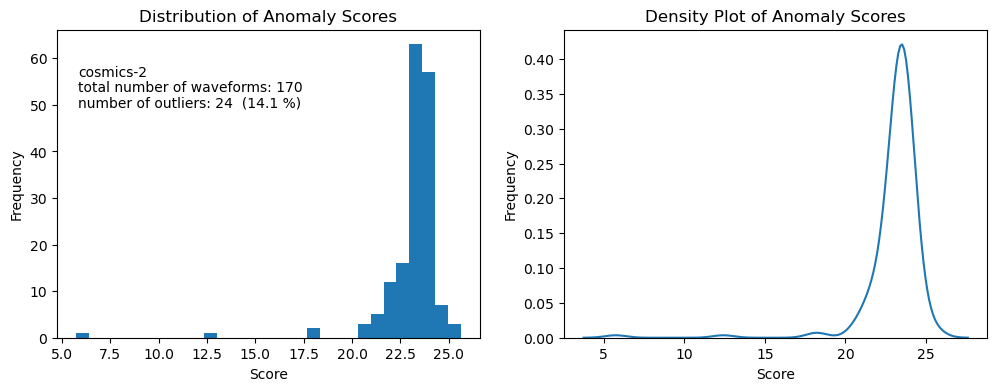

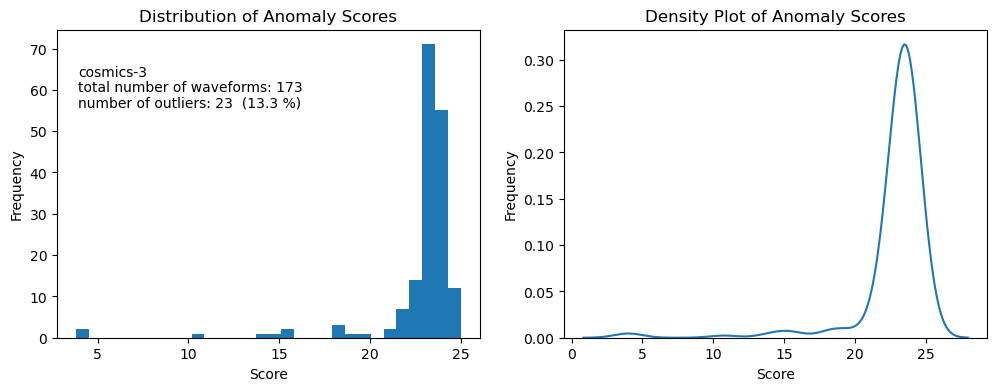

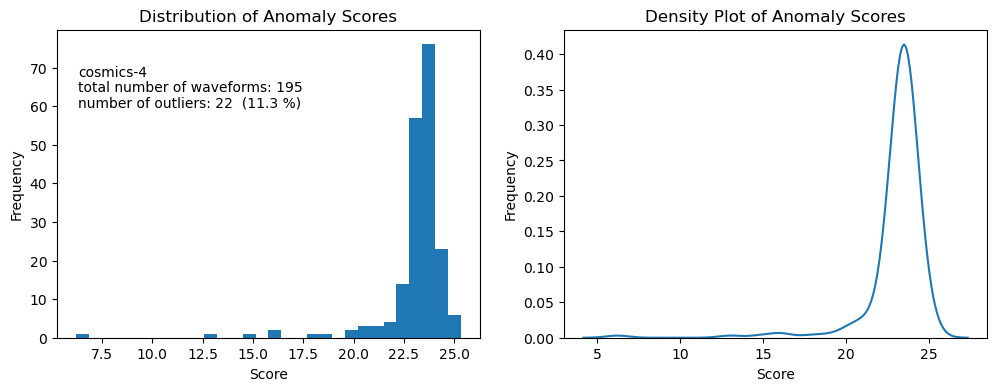

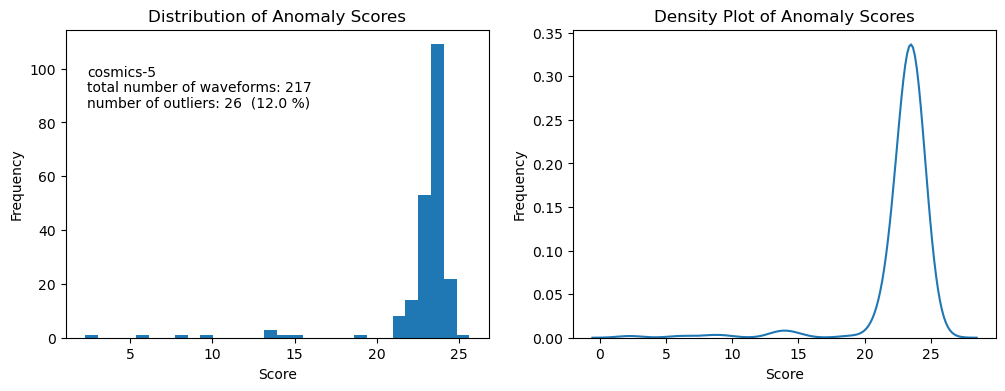

In [48]:
for file in [ 'cosmics-1', 'cosmics-2' ,'cosmics-3', 'cosmics-4', 'cosmics-5' ]: 
    print('\n', file)
    c_test = pd.read_pickle(f'{file}.pkl')
    c_test_vect, _ = make_training_sample(c_test['waveform'], verbose=False, nWfs_plot=20, force_max = max)
    print(c_test_vect.shape)
    y_pred = ocsvm.predict(c_test_vect) 
    Ntot, Nanomalies = print_info(y_pred, False)
    LLH = ocsvm.score_samples(c_test_vect) ## get log-likelihood of a data point under the learned density model
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    ax = axs[0]
    ax.hist(LLH, bins=30)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Anomaly Scores');
    ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
    ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
    ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
    ax = axs[1]
    sns.kdeplot(LLH)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Density Plot of Anomaly Scores');



## Inference (on neutron samples)


 neutrons
mean: 208.3, min = 61, max = 450 
maximum 150 is taken from external input
(120, 150)

 neutrons_sideBand
mean: 193.4, min = 72, max = 450 
maximum 150 is taken from external input
(1337, 150)


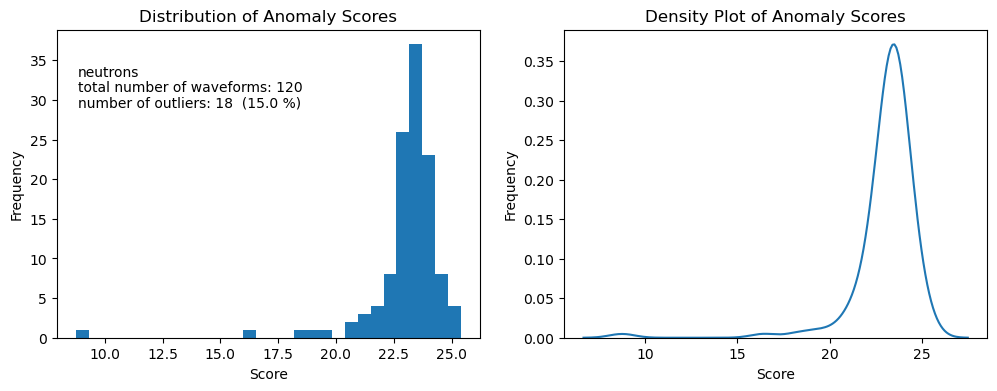

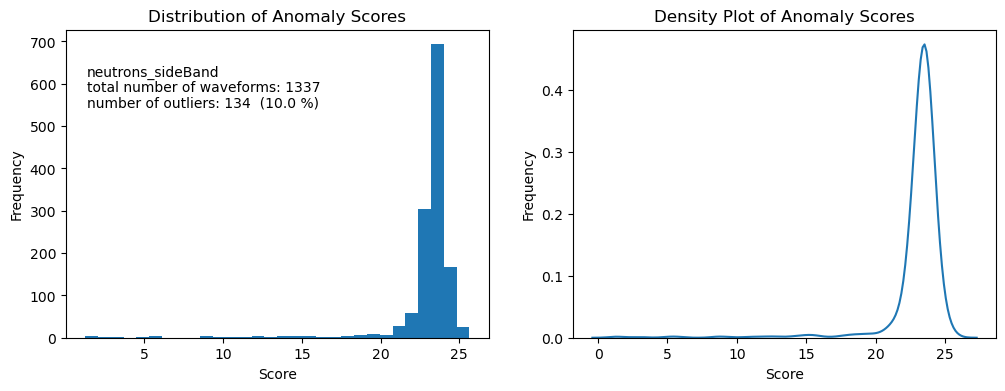

In [49]:
for file in [ 'neutrons', 'neutrons_sideBand']: 
    print('\n', file)
    c_test = pd.read_pickle(f'{file}.pkl')
    c_test_vect, _ = make_training_sample(c_test['waveform'], verbose=False, nWfs_plot=20, force_max = max)
    print(c_test_vect.shape)
    y_pred = ocsvm.predict(c_test_vect) 
    Ntot, Nanomalies = print_info(y_pred, False)
    LLH = ocsvm.score_samples(c_test_vect) ## get log-likelihood of a data point under the learned density model
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    ax = axs[0]
    ax.hist(LLH, bins=30)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Anomaly Scores');
    ax.text(0.05, 0.85, f'{file}', transform=ax.transAxes);
    ax.text(0.05, 0.8, f'total number of waveforms: {Ntot}', transform=ax.transAxes);
    ax.text(0.05, 0.75, f'number of outliers: {Nanomalies}  ({Nanomalies*100/Ntot:.1f} %)', transform=ax.transAxes);
    ax = axs[1]
    sns.kdeplot(LLH)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Density Plot of Anomaly Scores');

# Draft: improvements

mean: 192.0, min = 83, max = 446 


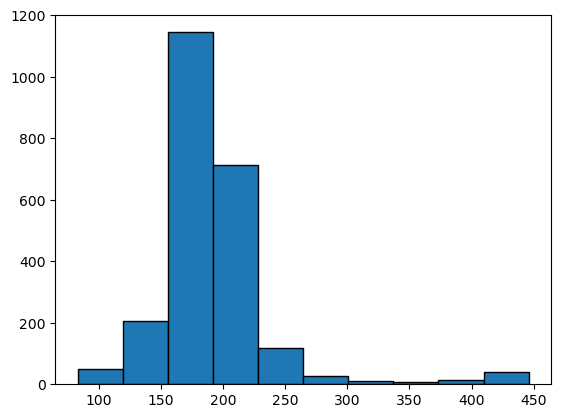

In [42]:
file = 'cosmics-1'
test = pd.read_pickle(f'{file}.pkl')
waveforms = test['waveform']
lengths = [wf.shape[0] for wf in waveforms]
mean, min, max = np.array(lengths).mean(), np.array(lengths).min(), np.array(lengths).max()
print(f'mean: {mean:.1f}, min = {min}, max = {max} ')
plt.hist(lengths, bins=10, edgecolor='black');


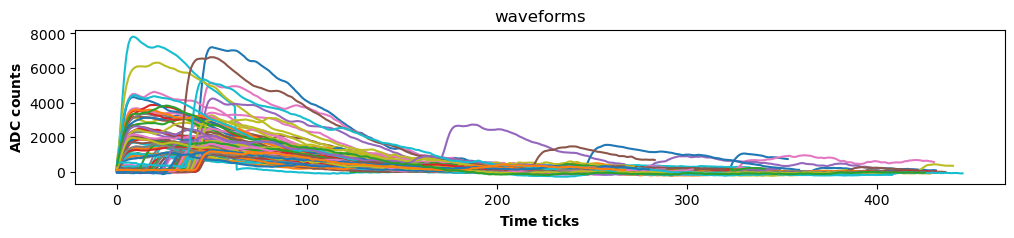

In [43]:
filtered_list = [arr for arr in waveforms if (len(arr) >= 250) ]
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
quick_plot(filtered_list, title='waveforms', axis =axs)